In [1]:
# tools 
import os 

# custom 
from gaussian_2D_render import GaussianSplatRenderer2D
from gaussian_3D_render import GaussianSplatRenderer3D
from utils import getProjectionMatrix, focal2fov

# math 
import torch 
import numpy as np 

# visualization 
import matplotlib.pyplot as plt 
import matplotlib

DEVICE = 'cpu'


In [2]:
def get_inputs(num_points=8):
    length = 0.5
    x = np.linspace(-1, 1, num_points) * length
    y = np.linspace(-1, 1, num_points) * length
    x, y = np.meshgrid(x, y)
    means3D = torch.from_numpy(np.stack([x,y, 0 * np.random.rand(*x.shape)], axis=-1).reshape(-1,3)).to(DEVICE).float()
    quats = torch.zeros(1,4).repeat(len(means3D), 1).to(DEVICE)
    quats[..., 0] = 1. # tangent vectors are the canonical basis 
    scale = length /(num_points-1) 
    scales = torch.zeros(1,3).repeat(len(means3D), 1).fill_(scale).to(DEVICE) # ellipsoids without deformation i.e. circles 
    return means3D, scales, quats

def get_cameras():
    intrins = torch.tensor([[711.1111,   0.0000, 256.0000,   0.0000],
               [  0.0000, 711.1111, 256.0000,   0.0000],
               [  0.0000,   0.0000,   1.0000,   0.0000],
               [  0.0000,   0.0000,   0.0000,   1.0000]]).to(DEVICE)
    c2w = torch.tensor([[-8.6086e-01,  3.7950e-01, -3.3896e-01,  6.7791e-01],
         [ 5.0884e-01,  6.4205e-01, -5.7346e-01,  1.1469e+00],
         [ 1.0934e-08, -6.6614e-01, -7.4583e-01,  1.4917e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]).to(DEVICE)

    width, height = 512, 512
    focal_x, focal_y = intrins[0, 0], intrins[1, 1]
    viewmat = torch.linalg.inv(c2w).permute(1,0)
    FoVx = focal2fov(focal_x, width)
    FoVy = focal2fov(focal_y, height)
    projmat = getProjectionMatrix(znear=0.2, zfar=1000, fovX=FoVx, fovY=FoVy).transpose(0,1).to(DEVICE)
    projmat = viewmat @ projmat
    return intrins, viewmat, projmat, height, width


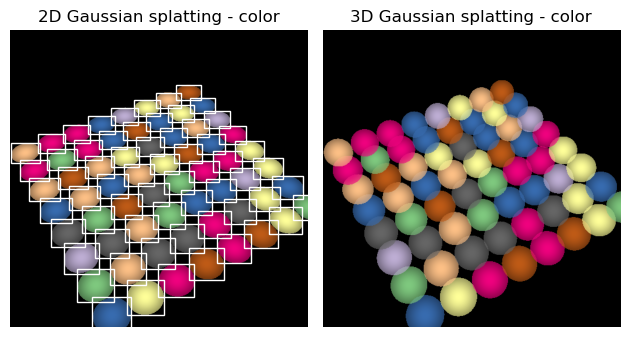

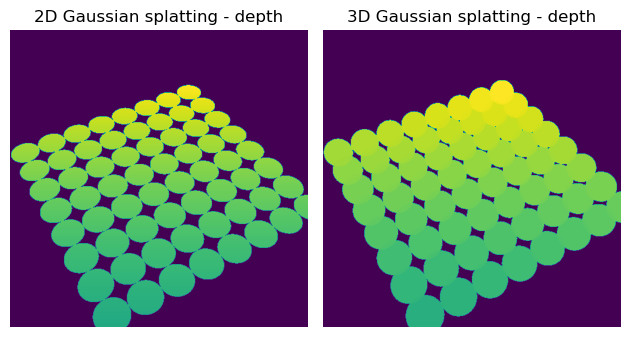

In [25]:
# Make inputs
num_points1=8
means3D, scales, quats = get_inputs(num_points=num_points1)
intrins, viewmat, projmat, height, width = get_cameras()
intrins = intrins[:3,:3]
colors = matplotlib.colormaps['Accent'](np.random.randint(1,64, 64)/64)[..., :3]
colors = torch.from_numpy(colors).to(DEVICE)
opacity = torch.ones_like(means3D[:,:1])

gaussian_2D = GaussianSplatRenderer2D()
gaussian_2D.means3D   = means3D
gaussian_2D.scales    = scales
gaussian_2D.quats     = quats
gaussian_2D.opacities = opacity
gaussian_2D.colors    = colors
gaussian_2D.viewmat   = viewmat
gaussian_2D.projmat   = projmat
gaussian_2D.intrins   = intrins

gaussian_3D = GaussianSplatRenderer3D()
gaussian_3D.means3D   = means3D
gaussian_3D.scales    = scales
gaussian_3D.quats     = quats
gaussian_3D.opacities = opacity
gaussian_3D.colors    = colors
gaussian_3D.viewmat   = viewmat
gaussian_3D.projmat   = projmat
gaussian_3D.intrins   = intrins

image1, depthmap1, center1, radii1, dist1 = gaussian_2D.surface_splatting()
image2, depthmap2, center2, radii2, dist2 = gaussian_3D.volume_splatting()

# Visualize 3DGS and 2DGS
fig1, (ax1,ax2) = plt.subplots(1,2)
fig2, (ax3,ax4) = plt.subplots(1,2)

from matplotlib.patches import Rectangle
point_image = center1.cpu().detach().numpy()
half_extend = radii1.cpu().numpy() * 1/3 # only show one sigma
lb = np.floor(point_image - half_extend)[..., :2]
hw = np.ceil(2*(half_extend)[..., :2])

ax1.set_aspect('equal')
ax1.set_axis_off()
ax1.set_title('2D Gaussian splatting - color')
ax2.set_aspect('equal')
ax2.set_axis_off()
ax2.set_title('3D Gaussian splatting - color')
ax1.set_aspect('equal')
ax1.set_axis_off()

ax3.set_title('2D Gaussian splatting - depth')
ax3.set_axis_off()
ax3.set_aspect('equal')
ax4.set_axis_off()
ax4.set_title('3D Gaussian splatting - depth')
fig1.tight_layout()
fig2.tight_layout()
# visualize AABB
for k in range(len(half_extend)):
    ax1.add_patch(Rectangle(lb[k], hw[k, 0], hw[k, 1], facecolor='none', edgecolor='white'))
    # ax3.add_patch(Rectangle(lb[k], hw[k, 0], hw[k, 1], facecolor='none', edgecolor='white'))

img1 = image1.cpu().numpy()
img2 = image2.cpu().numpy()
ax1.imshow(img1)
ax2.imshow(img2)

img1 = depthmap1.cpu().numpy()
img2 = depthmap2.cpu().numpy()

ax3.imshow(img1)
ax4.imshow(img2)


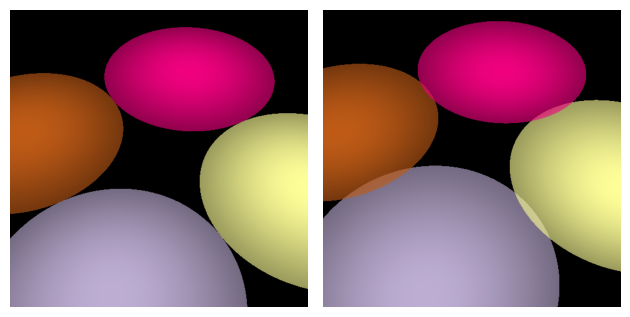

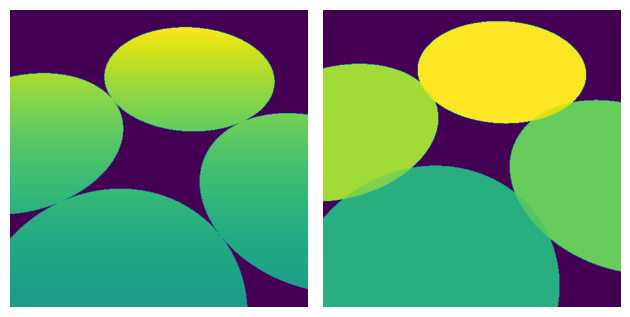

In [16]:
# reduce num of points to give a close look
num_points2=2
means3D, scales, quats = get_inputs(num_points=num_points2)
scales[:,-1] = 0e-6
colors = torch.cat([colors[:num_points2, :], colors[num_points1:num_points1+num_points2, :]], dim=0)

opacity = torch.ones_like(means3D[:,:1])

gaussian_2D = GaussianSplatRenderer2D()
gaussian_2D.means3D   = means3D
gaussian_2D.scales    = scales
gaussian_2D.quats     = quats
gaussian_2D.opacities = opacity
gaussian_2D.colors    = colors
gaussian_2D.viewmat   = viewmat
gaussian_2D.projmat   = projmat
gaussian_2D.intrins   = intrins

gaussian_3D = GaussianSplatRenderer3D()
gaussian_3D.means3D   = means3D
gaussian_3D.scales    = scales
gaussian_3D.quats     = quats
gaussian_3D.opacities = opacity
gaussian_3D.colors    = colors
gaussian_3D.viewmat   = viewmat
gaussian_3D.projmat   = projmat
gaussian_3D.intrins   = intrins

image1, depthmap1, center1, radii1, dist1 = gaussian_2D.surface_splatting()
image2, depthmap2, center2, radii2, dist2 = gaussian_3D.volume_splatting()

# Visualize 3DGS and 2DGS
fig1, (ax1,ax2) = plt.subplots(1,2)
fig2, (ax3,ax4) = plt.subplots(1,2)

from matplotlib.patches import Rectangle
point_image = center1.cpu().detach().numpy()
half_extend = radii1.cpu().numpy()
lb = np.floor(point_image - half_extend)[..., :2]
hw = np.ceil(2*(half_extend)[..., :2])

ax1.set_aspect('equal')
ax1.set_axis_off()
# ax1.set_title('2D Gaussian splatting - color')
ax2.set_aspect('equal')
ax2.set_axis_off()
# ax2.set_title('3D Gaussian splatting - color')
ax1.set_aspect('equal')
ax1.set_axis_off()

# ax3.set_title('2D Gaussian splatting - depth')
ax3.set_axis_off()
ax3.set_aspect('equal')
ax4.set_axis_off()
# ax4.set_title('3D Gaussian splatting - depth')
fig1.tight_layout()
fig2.tight_layout()

img1 = image1.cpu().numpy()
img2 = image2.cpu().numpy()
ax1.imshow(img1)
ax2.imshow(img2)

img1 = depthmap1.cpu().numpy()
img2 = depthmap2.cpu().numpy()

ax3.imshow(img1)
ax4.imshow(img2)


In [17]:
import numpy as np
import torch

def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = axis / np.linalg.norm(axis)
    a = np.cos(theta / 2.0)
    b, c, d = -axis * np.sin(theta / 2.0)
    rm = np.array([[a*a + b*b - c*c - d*d, 2*(b*c - a*d),     2*(b*d + a*c)],
                   [2*(b*c + a*d),     a*a + c*c - b*b - d*d, 2*(c*d - a*b)],
                   [2*(b*d - a*c),     2*(c*d + a*b),     a*a + d*d - b*b - c*c]])
    return torch.from_numpy(rm)

def look_at(eye, center, up):
    """
    Create a view matrix looking from eye to center with the given up vector.
    """
    eye = np.array(eye, dtype=np.float32)
    center = np.array(center, dtype=np.float32)
    up = np.array(up, dtype=np.float32)

    f = center - eye
    f /= np.linalg.norm(f)
    up /= np.linalg.norm(up)
    s = np.cross(f, up)
    u = np.cross(s, f)

    view_matrix = np.eye(4, dtype=np.float32)
    view_matrix[:3, 0] = s
    view_matrix[:3, 1] = u
    view_matrix[:3, 2] = -f
    view_matrix[:3, 3] = eye
    return torch.from_numpy(view_matrix)

def generate_circular_trajectory(center, radius, num_steps, up=[0, 1, 0]):
    """
    Generate camera poses along a circular trajectory around a center point.
    """
    cameras = []
    for t in np.linspace(0, 2 * np.pi, num_steps, endpoint=False):
        x = center[0] + radius * np.cos(t)
        y = center[1]
        z = center[2] + radius * np.sin(t)
        eye = [x, y, z]
        view_matrix = look_at(eye, center, up)
        cameras.append(view_matrix)
    return cameras


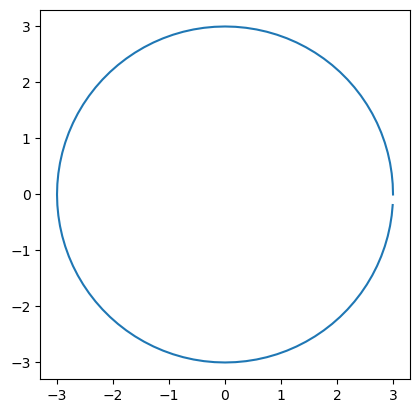

In [18]:
center = np.array([0, 0, 0])
radius = 3
num_steps = 100
cameras_circle = generate_circular_trajectory(center, radius, num_steps)

trajectory_circle = np.array([cameras_circle[j][:3, 3] for j in range(num_steps)])
fig, axe = plt.subplots()
axe.plot(trajectory_circle[:, 0], trajectory_circle[:, 2])
axe.set_aspect('equal')
plt.show()

In [22]:
def create_checkpoint_dir(checkpoint_dir : str):
    
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

        print(f'Checkpoint directory: {checkpoint_dir}')
    return checkpoint_dir

intrins = torch.tensor(
    [[711.1111,   0.0000, 256.0000,   0.0000],
    [  0.0000, 711.1111, 256.0000,   0.0000],
    [  0.0000,   0.0000,   1.0000,   0.0000],
    [  0.0000,   0.0000,   0.0000,   1.0000]]).to(DEVICE)
cameras = [cameras_circle[10], cameras_circle[30]]

# Make inputs
num_points1=8
means3D, scales, quats = get_inputs(num_points=num_points1)
colors  = matplotlib.colormaps['Accent'](np.random.randint(1,64, 64)/64)[..., :3]
colors  = torch.from_numpy(colors).to(DEVICE)
opacity = torch.ones_like(means3D[:,:1])
height, width = 512, 512

intrins = intrins[:3, :3]
projmat = torch.eye(4, dtype=torch.float)
projmat[:3,:3] = intrins
projmat[-1,-2] = 1.0
projmat = projmat.T

renders = {'images' : [], 'depths' : []}

gaussian_2D = GaussianSplatRenderer2D()

for c2w in cameras:
    
    viewmat = torch.linalg.inv(c2w).permute(1,0)

    gaussian_2D.means3D   = means3D
    gaussian_2D.scales    = scales
    gaussian_2D.quats     = quats
    gaussian_2D.opacities = opacity
    gaussian_2D.colors    = colors
    gaussian_2D.viewmat   = viewmat
    gaussian_2D.projmat   = projmat
    gaussian_2D.intrins   = intrins

    image, depthmap, center, radii, dist = gaussian_2D.surface_splatting()
    renders['images'].append(image)
    renders['depths'].append(depthmap)

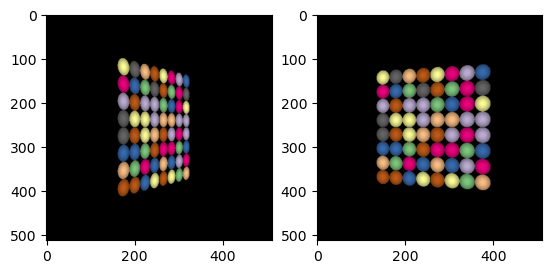

In [23]:
plt.subplot(121); plt.imshow(renders['images'][0].numpy())
plt.subplot(122); plt.imshow(renders['images'][1].numpy())
plt.show()

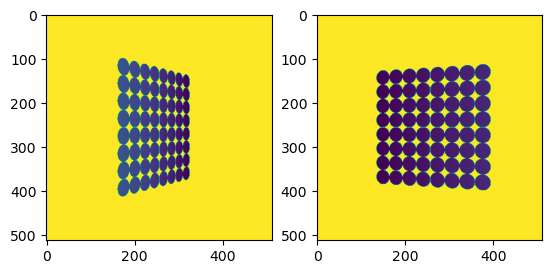

In [24]:
plt.subplot(121); plt.imshow(renders['depths'][0].numpy(), cmap='viridis')
plt.subplot(122); plt.imshow(renders['depths'][1].numpy(), cmap='viridis')
plt.show()

In [ ]:
from MonoGS.utils.slam_utils import get_loss_tracking